In [15]:
#conda install --channel conda-forge carterbox-torch-radon
#!pip install matplotlib
#!pip install opencv-python
#!sudo apt update && apt install -y libsm6 libxext6
#!sudo apt-get install -y libxrender-dev
#!nvidia-smi

In [16]:
import os
import s3fs
import torch
import json
import numpy as np
import torch_radon as tr
from matplotlib import pyplot as plt
from modules.operators.RadonTorch import RadonTorch

device = 'cuda'

In [59]:
# connection db

S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

BUCKET_X_TRUE_TRAIN = "antoinedp/x_true_train"
BUCKET_X_TRUE_VAL = "antoinedp/x_clem"

x_true_train_filenames = fs.ls(BUCKET_X_TRUE_TRAIN)[1:]
x_true_val_filenames = fs.ls(BUCKET_X_TRUE_VAL)[1:]

In [60]:
# load ground truth

def import_data(file_paths):
    data = []
    for file_path in file_paths:
        with fs.open(file_path, mode="rb") as file_in:
            data.append(np.load(file_in, encoding="bytes"))
    return data
    
x_true_train = import_data(x_true_train_filenames[:10])
x_true_val = import_data(x_true_val_filenames)

In [61]:
# set projector

angles = np.linspace(0, np.pi, 52, endpoint=False)
volume = tr.Volume2D()
volume.set_size(height=512, width=512)
radon = RadonTorch(512, angles, volume)


In [62]:
x_true_train_tensor = torch.from_numpy(np.array(x_true_train)).to(dtype=torch.float32).to(device).unsqueeze(1)
x_true_val_tensor = torch.from_numpy(np.array(x_true_val)).to(dtype=torch.float32).to(device).unsqueeze(1)

x_fbp_train_list = []
for xtrue_train in x_true_train_tensor:
    x_fbp_train_list.append(radon.fbp(xtrue_train))

x_fbp_val_list = []
for xtrue_val in x_true_val_tensor:
    x_fbp_val_list.append(radon.fbp(xtrue_val))

x_fbp_train_tensor = torch.stack(x_fbp_train_list)
x_fbp_val_tensor = torch.stack(x_fbp_val_list)


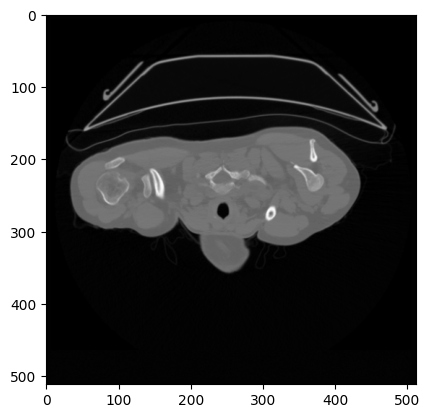

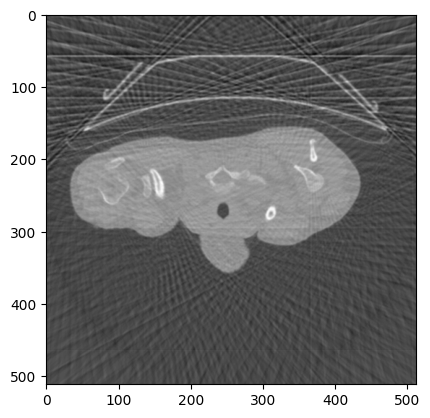

In [63]:
from matplotlib import pyplot as plt
plt.imshow(x_true_val_tensor[5].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()
plt.imshow(x_fbp_val_tensor[5].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()

In [64]:
mean_x_fbp_train = torch.mean(x_fbp_train_tensor)
std_x_fbp_train = torch.std(x_fbp_train_tensor)
mean_x_true_train = torch.mean(x_true_train_tensor)
std_x_true_train = torch.std(x_true_train_tensor)

In [65]:
print(mean_x_fbp_train)
print(std_x_fbp_train)
print(mean_x_true_train)
print(std_x_true_train)

tensor(0.0048, device='cuda:0')
tensor(0.0082, device='cuda:0')
tensor(0.0046, device='cuda:0')
tensor(0.0080, device='cuda:0')


In [66]:
import torch
from torchvision import transforms

class DualHorizontalVerticalFlip(object):
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, sample):
        input_image, output_image = sample['x'], sample['y']
        
        if torch.rand(1) < self.p:
            input_image = transforms.functional.hflip(input_image)
            output_image = transforms.functional.hflip(output_image)
        
        if torch.rand(1) < self.p:
            input_image = transforms.functional.vflip(input_image)
            output_image = transforms.functional.vflip(output_image)

        rotate_rand = torch.rand(1)

        if rotate_rand < self.p / 2:
            input_image = transforms.functional.rotate(input_image, angle = 90)
            output_image = transforms.functional.rotate(output_image, angle = 90)
        elif self.p / 2 <= rotate_rand < self.p:
            input_image = transforms.functional.rotate(input_image, angle = 180)
            output_image = transforms.functional.rotate(output_image, angle = 180)
        elif self.p <= rotate_rand < (1/2)*(1 + self.p):
            input_image = transforms.functional.rotate(input_image, angle = 270)
            output_image = transforms.functional.rotate(output_image, angle = 270) 
        else:
            pass
        
        return {'x': input_image, 'y': output_image}


In [67]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Define the transformation for flip-flop augmentation
flip_flop_transform = transforms.Compose([
    DualHorizontalVerticalFlip(p=0.5)
])

normalize_x_fbp = transforms.Compose([
    transforms.Normalize(mean=[mean_x_fbp_train], std=[std_x_fbp_train])
])

normalize_x_true = transforms.Compose([
    transforms.Normalize(mean=[mean_x_true_train], std=[std_x_true_train])
])

class CustomDataset(Dataset):
    
    def __init__(self, X, y, transform, target_transform, flip_flop_transform = None):
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        self.flip_flop_transform = flip_flop_transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

        x = self.transform(self.X[idx])
        y = self.target_transform(self.y[idx])

        if self.flip_flop_transform:
            sample = {'x': x, 'y': y}
            flip_flop_transform = self.flip_flop_transform(sample)
            x = flip_flop_transform['x']
            y = flip_flop_transform['y']
                    
        return x, y

dataloader_train = DataLoader(CustomDataset(x_fbp_train_tensor, x_true_train_tensor, normalize_x_fbp, normalize_x_true, flip_flop_transform), batch_size=1, shuffle=True)
dataloader_val = DataLoader(CustomDataset(x_fbp_val_tensor, x_true_val_tensor, normalize_x_fbp, normalize_x_true), batch_size=1, shuffle=True)

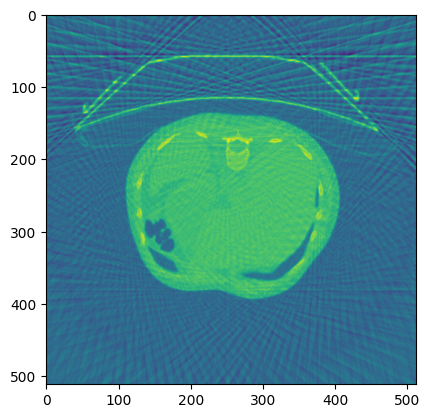

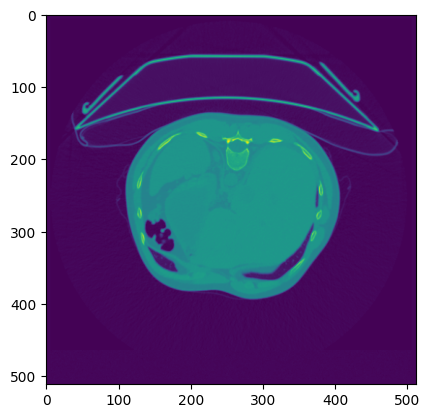

In [68]:
img_x, img_y = next(iter(dataloader_train))
img_x_, img_y_ = img_x[0].to('cpu').squeeze(0).squeeze(0).numpy(), img_y[0].to('cpu').squeeze(0).squeeze(0).numpy()
plt.imshow(img_x_)
plt.show()
plt.imshow(img_y_)
plt.show()

In [69]:
import torch.nn as nn

class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.mp = nn.MaxPool2d(2, stride=2)

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x, downsample=True):

        if downsample:
          x = self.mp(x)

        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))

        return x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.upconv = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn0 = nn.BatchNorm2d(in_channels//2)
        self.relu0 = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, in_channels//2, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels//2)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels//2, in_channels//2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels//2)
        self.relu2 = nn.ReLU()

    def forward(self, x1, x2):

        x1 = self.relu0(self.bn0(self.upconv(x1)))

        x = torch.cat([x2, x1], dim=1)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))

        return x


class UNet(nn.Module):
  def __init__(self, num_channels=1):
        super().__init__()

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        self.ds1 = DownSamplingBlock(64, 64)
        self.ds2 = DownSamplingBlock(64, 128)
        self.ds3 = DownSamplingBlock(128, 256)
        self.ds4 = DownSamplingBlock(256, 512)
        self.ds5 = DownSamplingBlock(512, 1024)

        self.us1 = UpSamplingBlock(1024)
        self.us2 = UpSamplingBlock(512)
        self.us3 = UpSamplingBlock(256)
        self.us4 = UpSamplingBlock(128)

        self.conv2 = nn.Conv2d(64, 1, 1)



  def forward(self, x):

      x0 = x
      x1 = self.relu1(self.bn1(self.conv1(x0)))
      
      x2 = self.ds1(x1, False)
      x3 = self.ds2(x2)
      x4 = self.ds3(x3)
      x5 = self.ds4(x4)
      x6 = self.ds5(x5)

      x7 = self.us1(x6, x5)
      x8 = self.us2(x7, x4)
      x9 = self.us3(x8, x3)
      x10 = self.us4(x9, x2)

      x11 = self.conv2(x10)
      x = x0 + x11
      return x
      

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, device):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        torch.nn.utils.clip_grad.clip_grad_value_(model.parameters(), clip_value=1e-1)
        optimizer.step()
        optimizer.zero_grad()

        # Display loss from time to time
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss: >7f}  [{current: >5d} / {size: >5d}]")
    
    scheduler.step()
    
def test_loop(dataloader, model, loss_fn, device, set = "Validation"):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"\n{set} set: Avg loss: {test_loss: >8f} \n")
    return test_loss


def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, epochs, device, start_epoch = 0, errors = {"train" : [], "val":[]}):
    for t in range(start_epoch, epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, device)
        
        torch.save({'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss_fn}, 
        	'./unet_l1.pth')
        
        loss_train = test_loop(train_dataloader, model, loss_fn, device, set = "Training")
        loss_val = test_loop(val_dataloader, model, loss_fn, device)
        
        errors["train"].append(loss_train)
        errors["val"].append(loss_val)

        with open('./data/errors/unet_l1', 'w') as json_file:
            json.dump(errors, json_file)

        

In [ ]:
#load model 
from torch.optim import lr_scheduler, SGD, Adam
import math


def lr_lambda(epoch):
    return math.exp(-0.07*epoch)


start_epoch = 0
epochs = 50
modelUnet = UNet().to(device)
optimizer = Adam(modelUnet.parameters(), lr=0.01)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
loss = nn.L1Loss()

# load model
#checkpoint = torch.load('./modelL1.pth')
#modelUnet.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#start_epoch = checkpoint['epoch']
#loss = checkpoint['loss']

train(model=modelUnet,
      train_dataloader=dataloader_train,
      val_dataloader=dataloader_val,
      loss_fn=loss,
      optimizer=optimizer,
      scheduler=scheduler,
      epochs=epochs,
      device=device,
      start_epoch=start_epoch)


Epoch 1
-------------------------------
loss: 0.574093  [    1 /  2000]
loss: 0.102733  [  101 /  2000]
loss: 0.085793  [  201 /  2000]
loss: 0.061903  [  301 /  2000]
loss: 0.073482  [  401 /  2000]
loss: 0.064901  [  501 /  2000]
loss: 0.061211  [  601 /  2000]
loss: 0.074484  [  701 /  2000]
loss: 0.048120  [  801 /  2000]
loss: 0.050572  [  901 /  2000]
loss: 0.056244  [ 1001 /  2000]
loss: 0.054794  [ 1101 /  2000]
loss: 0.060957  [ 1201 /  2000]
loss: 0.056107  [ 1301 /  2000]
loss: 0.050837  [ 1401 /  2000]
loss: 0.050317  [ 1601 /  2000]
loss: 0.057844  [ 1701 /  2000]
loss: 0.056739  [ 1801 /  2000]
loss: 0.051905  [ 1901 /  2000]

Training set: Avg loss: 0.054570 


Validation set: Avg loss: 0.055224 

Epoch 2
-------------------------------
loss: 0.062775  [    1 /  2000]
loss: 0.040922  [  101 /  2000]
loss: 0.043798  [  201 /  2000]
loss: 0.041261  [  301 /  2000]
loss: 0.037504  [  401 /  2000]
loss: 0.040222  [  501 /  2000]
loss: 0.036964  [  601 /  2000]
loss: 0.044121

In [73]:
# load model
checkpoint = torch.load('./unet_l1.pth')
modelUnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
start_epoch = checkpoint['epoch']
loss = checkpoint['loss']
modelUnet.eval()


UNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (ds1): DownSamplingBlock(
    (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (ds2): DownSamplingBlock(
    (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv

In [77]:
def psnr(original, reconstructed):

    # normalizing to have pixels between 0 and 1 to compute the peak signal to noise ratio
    noriginal = (original - np.min(original)) / (np.max(original) - np.min(original))
    nreconstructed = (reconstructed - np.min(reconstructed)) / (np.max(reconstructed) - np.min(reconstructed))

    # compute Mean Squared Error (MSE)
    mse = np.mean((noriginal - nreconstructed) ** 2)

    # compute PSNR in decibels
    if mse == 0:
        return float('inf')  # PSNR is infinite if the images are identical
    else:
        psnr_value = 10 * np.log10((1 ** 2) / mse) # 1 being the max pixel value / range of pixel values
        return psnr_value

psnr_list = []
for (img_x,img_y) in dataloader_val:
    img_x_, img_y_ = img_x[0].to('cpu').squeeze(0).squeeze(0).numpy(), img_y[0].to('cpu').squeeze(0).squeeze(0).numpy()
    z = modelUnet(img_x.to(device))
    pred = z.squeeze(0).squeeze(0).to('cpu').detach().numpy()
    psnr_list.append(psnr(pred, img_y_))

print(np.mean(psnr_list))
    

34.12101632251734


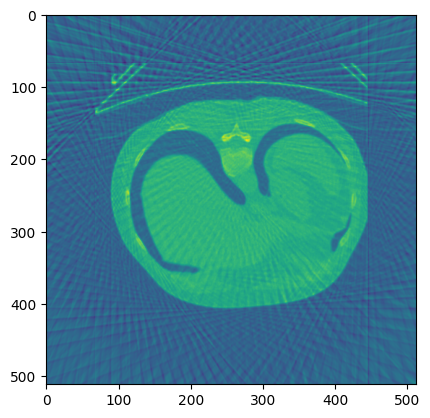

In [57]:
img_x, img_y = next(iter(dataloader_val))
img_x_, img_y_ = img_x[0].to('cpu').squeeze(0).squeeze(0).numpy(), img_y[0].to('cpu').squeeze(0).squeeze(0).numpy()
plt.imshow(img_x_)
plt.show()

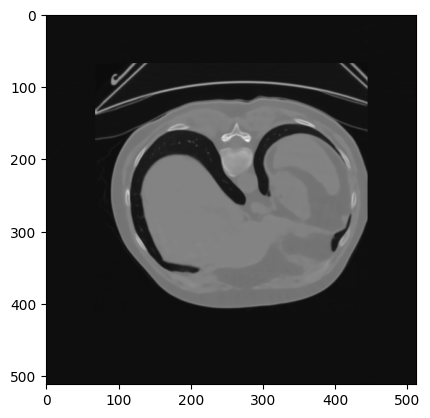

In [58]:
z = modelUnet(img_x.to(device))
plt.imshow(z.squeeze(0).squeeze(0).to('cpu').detach().numpy(), cmap="gray")
plt.show()

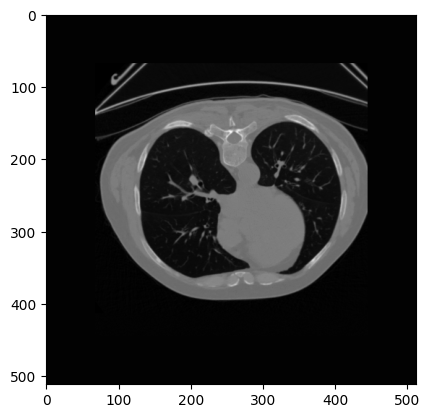

In [45]:
plt.imshow(img_y_, cmap="gray")
plt.show()